In [18]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

# Add the directory where dynamics.py and utils.py are located to sys.path
module_path = os.path.abspath(os.path.join('../src'))
if module_path not in sys.path:
    sys.path.append(module_path)

# Load tudatpy modules
from tudatpy.interface import spice
from tudatpy.util import result2array
from tudatpy import numerical_simulation
from dynamics import SatelliteDynamics, rv2coe
from utils import get_form_initial_conditions
from tudatpy.astro.time_conversion import DateTime
from tudatpy.numerical_simulation import environment_setup, propagation_setup, estimation_setup

In [19]:
# Load spice kernels
spice.load_standard_kernels()

# Set simulation start (0 TDB seconds since J2000) and end epochs
dt = 60.0
T = 3600
simulation_start_epoch = DateTime(2000, 1, 1).epoch()
simulation_end_epoch = (T - 1) * dt

In [20]:
# Create default body settings for "Venus", "Moon", "Earth", "Mars", "Jupiter", "Sun"
bodies_to_create = ["Sun", "Moon", "Venus", "Earth", "Mars", "Jupiter"]

# Create default body settings for bodies_to_create, with "Earth"/"J2000" as the global frame origin and orientation
global_frame_origin = "Earth"
global_frame_orientation = "J2000"
body_settings = environment_setup.get_default_body_settings(bodies_to_create, global_frame_origin, global_frame_orientation)
body_settings.get("Earth").atmosphere_settings = environment_setup.atmosphere.nrlmsise00()

# Create system of bodies
bodies = environment_setup.create_system_of_bodies(body_settings)

In [21]:
# Create vehicle objects and set their mass
spacecrafts = ["Chief", "Deputy1", "Deputy2", "Deputy3"]
for spacecraft in spacecrafts:
    bodies.create_empty_body(spacecraft)
    bodies.get(spacecraft).mass = SatelliteDynamics().m

# Add the aerodynamic interface to the environment
reference_area = SatelliteDynamics().A_drag
drag_coefficient = SatelliteDynamics().C_drag
aero_coefficient_settings = environment_setup.aerodynamic_coefficients.constant(reference_area, [drag_coefficient, 0.0, 0.0])
for spacecraft in spacecrafts:
    environment_setup.add_aerodynamic_coefficient_interface(bodies, spacecraft, aero_coefficient_settings)

In [22]:
# Define bodies that are propagated
bodies_to_propagate = ["Chief", "Deputy1", "Deputy2", "Deputy3"]

# Define central bodies of propagation
central_bodies = ["Earth", "Earth", "Earth", "Earth"]

In [23]:
# Define radiation pressure settings
reference_area_radiation = reference_area
radiation_pressure_coefficient = 1.2
occulting_bodies_dict = dict()
occulting_bodies_dict["Sun"] = ["Moon", "Earth"]

# Create and add the radiation pressure interface to the environment
radiation_pressure_settings = environment_setup.radiation_pressure.cannonball(
    "Sun", reference_area_radiation, radiation_pressure_coefficient, occulting_bodies=occulting_bodies_dict["Sun"]
    )
for spacecraft in spacecrafts:
    environment_setup.add_radiation_pressure_interface(
        bodies, spacecraft, radiation_pressure_settings
    )
# Warning: https://docs.tudat.space/en/latest/_src_user_guide/state_propagation/propagation_setup/translational/radiation_pressure_acceleration.html#backwards-compatibility
    
# Define accelerations acting on each vehicle
#   1. Earth’s gravity field EGM96 spherical harmonic expansion up to degree and order 12
#   2. Atmospheric drag NRLMSISE-00 model
#   3. Cannon ball solar radiation pressure, assuming constant reflectivity coefficient and radiation area
#   4. Third-body perturbations of the Sun, Moon, Venus, Mars and Jupiter
accelerations_settings = dict(
    Sun=[propagation_setup.acceleration.point_mass_gravity(), propagation_setup.acceleration.cannonball_radiation_pressure()],
    Moon=[propagation_setup.acceleration.point_mass_gravity()],
    Venus=[propagation_setup.acceleration.point_mass_gravity()],
    Earth=[propagation_setup.acceleration.spherical_harmonic_gravity(12, 12), propagation_setup.acceleration.aerodynamic()],
    Mars=[propagation_setup.acceleration.point_mass_gravity()],
    Jupiter=[propagation_setup.acceleration.point_mass_gravity()]
)

# Create global accelerations settings dictionary
acceleration_settings = {"Chief": accelerations_settings,
                         "Deputy1": accelerations_settings,
                         "Deputy2": accelerations_settings,
                         "Deputy3": accelerations_settings}               

# Create acceleration models
acceleration_models = propagation_setup.create_acceleration_models(
    bodies,
    acceleration_settings,
    bodies_to_propagate,
    central_bodies)

Warning, you are using the deprecated (as of tudatpy v0.8) version of the cannonball radiation pressure model, the interface you are using will be dropped from v0.9 onwards. To learn how to convert your code to the new interfaces, and be able to use the powerful new radiation pressure framework, see https://docs.tudat.space/en/latest/_src_user_guide/state_propagation/propagation_setup/translational/radiation_pressure_acceleration.html#backwards-compatibility
Warning, you are using the deprecated (as of tudatpy v0.8) version of the cannonball radiation pressure model, the interface you are using will be dropped from v0.9 onwards. To learn how to convert your code to the new interfaces, and be able to use the powerful new radiation pressure framework, see https://docs.tudat.space/en/latest/_src_user_guide/state_propagation/propagation_setup/translational/radiation_pressure_acceleration.html#backwards-compatibility
Warning, you are using the deprecated (as of tudatpy v0.8) version of the 

In [56]:
# Create initial state
initial_states = get_form_initial_conditions(1)

# Create termination settings
termination_condition = propagation_setup.propagator.time_termination(simulation_end_epoch)

# Create numerical integrator settings
fixed_step_size = dt
integrator_settings = propagation_setup.integrator.runge_kutta_4(fixed_step_size)

# Create propagation settings
propagator_settings = propagation_setup.propagator.translational(
    central_bodies,
    acceleration_models,
    bodies_to_propagate,
    initial_states,
    simulation_start_epoch,
    integrator_settings,
    termination_condition
)

# Setup parameters settings to propagate the state transition matrix
parameter_settings = estimation_setup.parameter.initial_states(propagator_settings, bodies)

# Create the parameters that will be estimated
parameters_to_estimate = estimation_setup.create_parameter_set(parameter_settings, bodies)

# Create the variational equation solver and propagate the dynamics
variational_equations_solver = numerical_simulation.create_variational_equations_solver(
    bodies, propagator_settings, parameters_to_estimate, simulate_dynamics_on_creation=True
)

# Extract the resulting state history, state transition matrix history, and sensitivity matrix history
states = variational_equations_solver.state_history
state_transition_matrices = variational_equations_solver.state_transition_matrix_history
X_tudat = result2array(states)[:, 1:]

In [57]:
# T = dt s simulation starting at the true state
X_our_model = np.zeros((T, 24))
X_our_model[0, :] = initial_states.reshape(24)
for t, X_t in enumerate(X_tudat):
    if t < T - 1:
        X_our_model[t + 1, :] = SatelliteDynamics().x_new(dt, X_t.reshape(24, 1)).reshape(24)

# Compute the difference between the ground truth and the model
diff = X_tudat[1:, :] - X_our_model[1:, :]

# The new shape will be (T * 24, 1) where each column represents a different state variable
diff_flattened = diff.reshape(-1, 24)

# Calculate the general covariance matrix of the flattened differences
Q = np.cov(diff_flattened, rowvar=False)
Q_chief = Q[:6, :6]
Q_deputy1 = Q[6:12, 6:12]
Q_deputy2 = Q[12:18, 12:18]
Q_deputy3 = Q[18:, 18:]

In [58]:
def print_Q_matrix(Q, which):
    # Set NumPy print options for scientific notation
    np.set_printoptions(precision=4, suppress=False, formatter={'float_kind': '{:0.4e}'.format})
    
    print(f'Matrix Q for {which}:')
    print('- Position covariance matrix diagonal:')
    print(np.diag(Q[:3, :3]))
    
    print('- Position-velocity covariance matrix diagonal:')
    print(np.diag(Q[:3, 3:]))
    
    print('- Velocity covariance matrix diagonal:')
    print(np.diag(Q[3:, 3:]))
    
    # Reset NumPy print options to default after use (if needed)
    np.set_printoptions()

In [59]:
print_Q_matrix(Q_chief, 'Chief')
print()
print_Q_matrix(Q_deputy1, 'Deputy1')
print()
print_Q_matrix(Q_deputy2, 'Deputy2')
print()
print_Q_matrix(Q_deputy3, 'Deputy3')

Matrix Q for Chief:
- Position covariance matrix diagonal:
[3.5558e-02 2.4744e-02 3.5679e-02]
- Position-velocity covariance matrix diagonal:
[1.1826e-03 8.2392e-04 1.1870e-03]
- Velocity covariance matrix diagonal:
[3.9422e-05 2.7454e-05 3.9581e-05]

Matrix Q for Deputy1:
- Position covariance matrix diagonal:
[3.5535e-02 2.4735e-02 3.5659e-02]
- Position-velocity covariance matrix diagonal:
[1.1818e-03 8.2362e-04 1.1863e-03]
- Velocity covariance matrix diagonal:
[3.9398e-05 2.7444e-05 3.9559e-05]

Matrix Q for Deputy2:
- Position covariance matrix diagonal:
[3.5589e-02 2.4750e-02 3.5699e-02]
- Position-velocity covariance matrix diagonal:
[1.1836e-03 8.2411e-04 1.1876e-03]
- Velocity covariance matrix diagonal:
[3.9457e-05 2.7461e-05 3.9603e-05]

Matrix Q for Deputy3:
- Position covariance matrix diagonal:
[3.5507e-02 2.4670e-02 3.5610e-02]
- Position-velocity covariance matrix diagonal:
[1.1809e-03 8.2146e-04 1.1847e-03]
- Velocity covariance matrix diagonal:
[3.9366e-05 2.7372e-05

#### Position to latitude in ECI frame
$$\phi = \arctan_2\left(z, \sqrt{x^2 + y^2}\right)$$

#### Conversion from ECI frame to RTN/LVLH frame
$$\delta\mathbf{r}_\mathrm{ECI} = \mathbf{r} - \hat{\mathbf{r}}$$
$$\mathbf{e}_r = \frac{\mathbf{r}}{r}, \quad \mathbf{e}_t = \mathbf{e}_n \times \mathbf{e}_r, \quad \mathbf{e}_n = \frac{\mathbf{r} \times \mathbf{v}}{\|\mathbf{r} \times \mathbf{v}\|_2}$$
$$\delta\mathbf{r}_\mathrm{RTN} = \begin{bmatrix}\mathbf{e}_r & \mathbf{e}_t & \mathbf{e}_n\end{bmatrix}\delta\mathbf{r}_\mathrm{ECI}$$

In [60]:
def eci_to_rtn(x_true, x_est):
    r_true = x_true[:3]
    v_true = x_true[3:]
    r_est = x_est[:3]

    # Compute the position error in ECI frame
    delta_r_eci = r_true - r_est

    # Compute unit vectors for the RTN frame
    e_r = r_true / np.linalg.norm(r_true)
    e_n = np.cross(r_true, v_true)
    e_n = e_n / np.linalg.norm(e_n)
    e_t = np.cross(e_n, e_r)

    # Construct the ECI to RTN transformation matrix
    T_eci2rtn = np.vstack((e_r, e_t, e_n)).T

    # Transform the position error vector to RTN frame
    delta_r_rtn = np.dot(T_eci2rtn, delta_r_eci)
    
    return delta_r_rtn

In [62]:
mean_argument_of_latitudes = np.zeros((T, 4))
delta_r_rtn = np.zeros((T, 12))
for t in range(T):
    # Chief
    x_true = X_tudat[t, :6]
    x_est = X_our_model[t, :6]
    _, eccentricity, _, argument_of_periapsis, _, true_anomaly = rv2coe(x_true)
    eccentric_anomaly = 2 * np.arctan(np.sqrt((1 - eccentricity) / (1 + eccentricity)) * np.tan(true_anomaly / 2))
    mean_anomaly = eccentric_anomaly - eccentricity * np.sin(eccentric_anomaly)
    mean_argument_of_latitudes[t, 0] = mean_anomaly + argument_of_periapsis
    delta_r_rtn[t, :3] = eci_to_rtn(x_true, x_est)
    
    # Deputy 1
    x_true = X_tudat[t, 6:12]
    x_est = X_our_model[t, 6:12]
    _, eccentricity, _, argument_of_periapsis, _, true_anomaly = rv2coe(x_true)
    eccentric_anomaly = 2 * np.arctan(np.sqrt((1 - eccentricity) / (1 + eccentricity)) * np.tan(true_anomaly / 2))
    mean_anomaly = eccentric_anomaly - eccentricity * np.sin(eccentric_anomaly)
    mean_argument_of_latitudes[t, 1] = mean_anomaly + argument_of_periapsis
    delta_r_rtn[t, 3:6] = eci_to_rtn(x_true, x_est)
    
    # Deputy 2
    x_true = X_tudat[t, 12:18]
    x_est = X_our_model[t, 12:18]
    _, eccentricity, _, argument_of_periapsis, _, true_anomaly = rv2coe(x_true)
    eccentric_anomaly = 2 * np.arctan(np.sqrt((1 - eccentricity) / (1 + eccentricity)) * np.tan(true_anomaly / 2))
    mean_anomaly = eccentric_anomaly - eccentricity * np.sin(eccentric_anomaly)
    mean_argument_of_latitudes[t, 2] = mean_anomaly + argument_of_periapsis
    delta_r_rtn[t, 6:9] = eci_to_rtn(x_true, x_est)
    
    # Deputy 3
    x_true = X_tudat[t, 18:]
    x_est = X_our_model[t, 18:]
    _, eccentricity, _, argument_of_periapsis, _, true_anomaly = rv2coe(x_true)
    eccentric_anomaly = 2 * np.arctan(np.sqrt((1 - eccentricity) / (1 + eccentricity)) * np.tan(true_anomaly / 2))
    mean_anomaly = eccentric_anomaly - eccentricity * np.sin(eccentric_anomaly)
    mean_argument_of_latitudes[t, 3] = mean_anomaly + argument_of_periapsis
    delta_r_rtn[t, 9:] = eci_to_rtn(x_true, x_est)

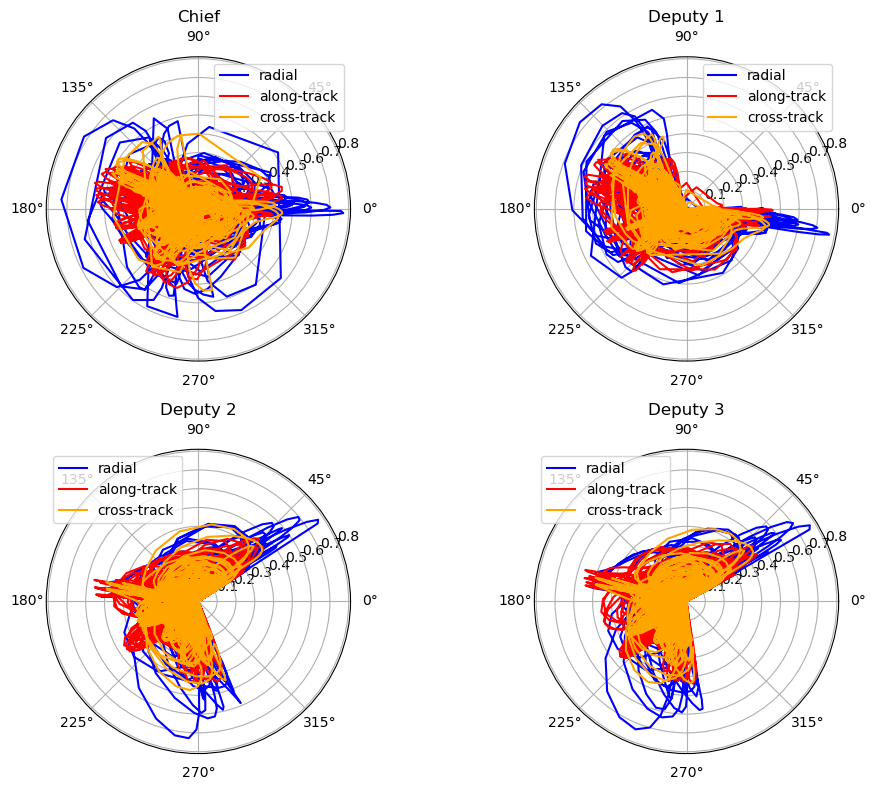

In [66]:
# Create a 2 by 2 subplot layout
fig, axs = plt.subplots(2, 2, subplot_kw={'projection': 'polar'}, figsize=(10, 8))

# Flatten the array of axes for easy access
axs = axs.flatten()

# First subplot
axs[0].plot(mean_argument_of_latitudes[:, 0], np.abs(delta_r_rtn[:, 0]), label=r'radial', color='blue')
axs[0].plot(mean_argument_of_latitudes[:, 0], np.abs(delta_r_rtn[:, 1]), label=r'along-track', color='red')
axs[0].plot(mean_argument_of_latitudes[:, 0], np.abs(delta_r_rtn[:, 2]), label=r'cross-track', color='orange')
axs[0].legend()
axs[0].set_title("Chief")

# Second subplot
axs[1].plot(mean_argument_of_latitudes[:, 1], np.abs(delta_r_rtn[:, 3]), label=r'radial', color='blue')
axs[1].plot(mean_argument_of_latitudes[:, 1], np.abs(delta_r_rtn[:, 4]), label=r'along-track', color='red')
axs[1].plot(mean_argument_of_latitudes[:, 1], np.abs(delta_r_rtn[:, 5]), label=r'cross-track', color='orange')
axs[1].legend()
axs[1].set_title("Deputy 1")

# Third subplot
axs[2].plot(mean_argument_of_latitudes[:, 2], np.abs(delta_r_rtn[:, 6]), label=r'radial', color='blue')
axs[2].plot(mean_argument_of_latitudes[:, 2], np.abs(delta_r_rtn[:, 7]), label=r'along-track', color='red')
axs[2].plot(mean_argument_of_latitudes[:, 2], np.abs(delta_r_rtn[:, 8]), label=r'cross-track', color='orange')
axs[2].legend()
axs[2].set_title("Deputy 2")

# Fourth subplot
axs[3].plot(mean_argument_of_latitudes[:, 3], np.abs(delta_r_rtn[:, 9]), label=r'radial', color='blue')
axs[3].plot(mean_argument_of_latitudes[:, 3], np.abs(delta_r_rtn[:, 10]), label=r'along-track', color='red')
axs[3].plot(mean_argument_of_latitudes[:, 3], np.abs(delta_r_rtn[:, 11]), label=r'cross-track', color='orange')
axs[3].legend()
axs[3].set_title("Deputy 3")

# Display the figure
plt.tight_layout()
plt.show()

In [67]:
# Dead-reckoning
X_our_model_dead_reckoning = np.zeros((T, 24))
X_our_model_dead_reckoning[0, :] = initial_states.reshape(24)
for t, X_t in enumerate(X_tudat):
    if t < T - 1:
        X_our_model_dead_reckoning[t + 1, :] = SatelliteDynamics().x_new(dt, X_our_model_dead_reckoning[t, :].reshape(24, 1)).reshape(24)

In [70]:
mean_argument_of_latitudes = np.zeros((T, 4))
delta_r_rtn = np.zeros((T, 12))
for t in range(T):
    # Chief
    x_true = X_tudat[t, :6]
    x_est = X_our_model_dead_reckoning[t, :6]
    _, eccentricity, _, argument_of_periapsis, _, true_anomaly = rv2coe(x_true)
    eccentric_anomaly = 2 * np.arctan(np.sqrt((1 - eccentricity) / (1 + eccentricity)) * np.tan(true_anomaly / 2))
    mean_anomaly = eccentric_anomaly - eccentricity * np.sin(eccentric_anomaly)
    mean_argument_of_latitudes[t, 0] = mean_anomaly + argument_of_periapsis
    delta_r_rtn[t, :3] = eci_to_rtn(x_true, x_est)
    
    # Deputy 1
    x_true = X_tudat[t, 6:12]
    x_est = X_our_model_dead_reckoning[t, 6:12]
    _, eccentricity, _, argument_of_periapsis, _, true_anomaly = rv2coe(x_true)
    eccentric_anomaly = 2 * np.arctan(np.sqrt((1 - eccentricity) / (1 + eccentricity)) * np.tan(true_anomaly / 2))
    mean_anomaly = eccentric_anomaly - eccentricity * np.sin(eccentric_anomaly)
    mean_argument_of_latitudes[t, 1] = mean_anomaly + argument_of_periapsis
    delta_r_rtn[t, 3:6] = eci_to_rtn(x_true, x_est)
    
    # Deputy 2
    x_true = X_tudat[t, 12:18]
    x_est = X_our_model_dead_reckoning[t, 12:18]
    _, eccentricity, _, argument_of_periapsis, _, true_anomaly = rv2coe(x_true)
    eccentric_anomaly = 2 * np.arctan(np.sqrt((1 - eccentricity) / (1 + eccentricity)) * np.tan(true_anomaly / 2))
    mean_anomaly = eccentric_anomaly - eccentricity * np.sin(eccentric_anomaly)
    mean_argument_of_latitudes[t, 2] = mean_anomaly + argument_of_periapsis
    delta_r_rtn[t, 6:9] = eci_to_rtn(x_true, x_est)
    
    # Deputy 3
    x_true = X_tudat[t, 18:]
    x_est = X_our_model_dead_reckoning[t, 18:]
    _, eccentricity, _, argument_of_periapsis, _, true_anomaly = rv2coe(x_true)
    eccentric_anomaly = 2 * np.arctan(np.sqrt((1 - eccentricity) / (1 + eccentricity)) * np.tan(true_anomaly / 2))
    mean_anomaly = eccentric_anomaly - eccentricity * np.sin(eccentric_anomaly)
    mean_argument_of_latitudes[t, 3] = mean_anomaly + argument_of_periapsis
    delta_r_rtn[t, 9:] = eci_to_rtn(x_true, x_est)

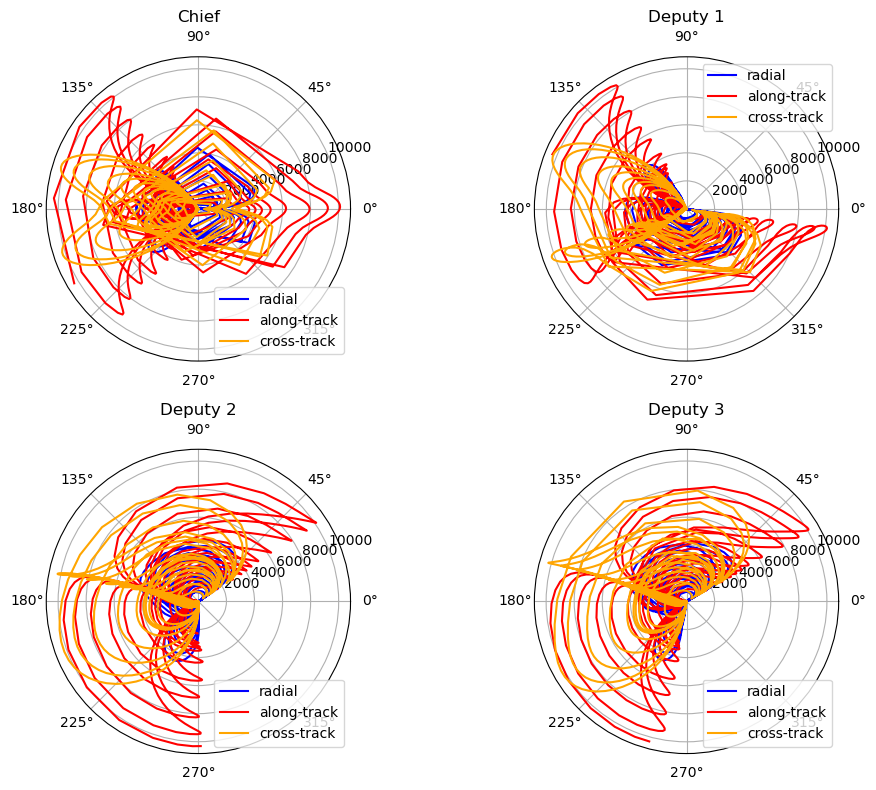

In [71]:
# Create a 2 by 2 subplot layout
fig, axs = plt.subplots(2, 2, subplot_kw={'projection': 'polar'}, figsize=(10, 8))

# Flatten the array of axes for easy access
axs = axs.flatten()

# First subplot
axs[0].plot(mean_argument_of_latitudes[:1000, 0], np.abs(delta_r_rtn[:1000, 0]), label=r'radial', color='blue')
axs[0].plot(mean_argument_of_latitudes[:1000, 0], np.abs(delta_r_rtn[:1000, 1]), label=r'along-track', color='red')
axs[0].plot(mean_argument_of_latitudes[:1000, 0], np.abs(delta_r_rtn[:1000, 2]), label=r'cross-track', color='orange')
axs[0].legend()
axs[0].set_title("Chief")

# Second subplot
axs[1].plot(mean_argument_of_latitudes[:1000, 1], np.abs(delta_r_rtn[:1000, 3]), label=r'radial', color='blue')
axs[1].plot(mean_argument_of_latitudes[:1000, 1], np.abs(delta_r_rtn[:1000, 4]), label=r'along-track', color='red')
axs[1].plot(mean_argument_of_latitudes[:1000, 1], np.abs(delta_r_rtn[:1000, 5]), label=r'cross-track', color='orange')
axs[1].legend()
axs[1].set_title("Deputy 1")

# Third subplot
axs[2].plot(mean_argument_of_latitudes[:1000, 2], np.abs(delta_r_rtn[:1000, 6]), label=r'radial', color='blue')
axs[2].plot(mean_argument_of_latitudes[:1000, 2], np.abs(delta_r_rtn[:1000, 7]), label=r'along-track', color='red')
axs[2].plot(mean_argument_of_latitudes[:1000, 2], np.abs(delta_r_rtn[:1000, 8]), label=r'cross-track', color='orange')
axs[2].legend()
axs[2].set_title("Deputy 2")

# Fourth subplot
axs[3].plot(mean_argument_of_latitudes[:1000, 3], np.abs(delta_r_rtn[:1000, 9]), label=r'radial', color='blue')
axs[3].plot(mean_argument_of_latitudes[:1000, 3], np.abs(delta_r_rtn[:1000, 10]), label=r'along-track', color='red')
axs[3].plot(mean_argument_of_latitudes[:1000, 3], np.abs(delta_r_rtn[:1000, 11]), label=r'cross-track', color='orange')
axs[3].legend()
axs[3].set_title("Deputy 3")

# Display the figure
plt.tight_layout()
plt.show()